# Model creation (superresolution)
At the moment only on Z component

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

In [12]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tools import common_functions as cf
from tools import regression as reg
from tools import plotting_functions as pf

# Parameters
SENSOR_LAG = 25 # ms
ARRAY_W = 2
ARRAY_H = 2
NR_SUBREGIONS = 1
DATA_NORMAL_FORCE_FILE = f"table_calibration/2x2_grid_subsampling_x{NR_SUBREGIONS}_08032024_schroef2_designremko"

# Automated
ARRAY_SIZE = ARRAY_W * ARRAY_H
ARRAY_SIZE_SUB = (ARRAY_W + (ARRAY_W - 1) * (NR_SUBREGIONS - 1)) * (ARRAY_H + (ARRAY_H - 1) * (NR_SUBREGIONS - 1))
data_columns = [f'X{i}' for i in range(ARRAY_SIZE)] + [f'Y{i}' for i in range(ARRAY_SIZE)] + [f'Z{i}' for i in range(ARRAY_SIZE)]


# Option 1
Split into regions of each taxel, then train one model per taxel 
A model is thus 3 inputs -> 3 outputs

In [13]:
normal_force_df = cf.prepare_data_for_fitting(DATA_NORMAL_FORCE_FILE, ARRAY_SIZE, SENSOR_LAG)
normal_force_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17451 entries, 3 to 17453
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   17451 non-null  int64  
 1   t_wall  17451 non-null  float64
 2   X0      17451 non-null  float64
 3   Y0      17451 non-null  float64
 4   Z0      17451 non-null  float64
 5   X1      17451 non-null  float64
 6   Y1      17451 non-null  float64
 7   Z1      17451 non-null  float64
 8   X2      17451 non-null  float64
 9   Y2      17451 non-null  float64
 10  Z2      17451 non-null  float64
 11  X3      17451 non-null  float64
 12  Y3      17451 non-null  float64
 13  Z3      17451 non-null  float64
 14  F_x     17451 non-null  float64
 15  F_y     17451 non-null  float64
 16  F_z     17451 non-null  float64
 17  T_x     17451 non-null  float64
 18  T_y     17451 non-null  float64
 19  T_z     17451 non-null  float64
 20  X       17451 non-null  float64
 21  Y       17451 non-null  float64
 22

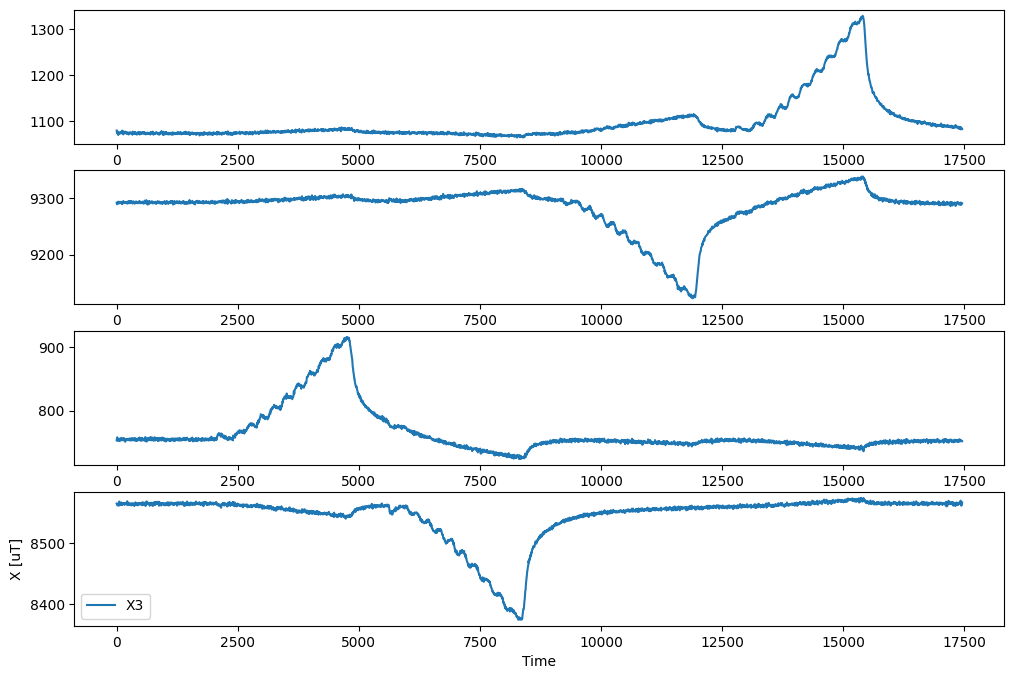

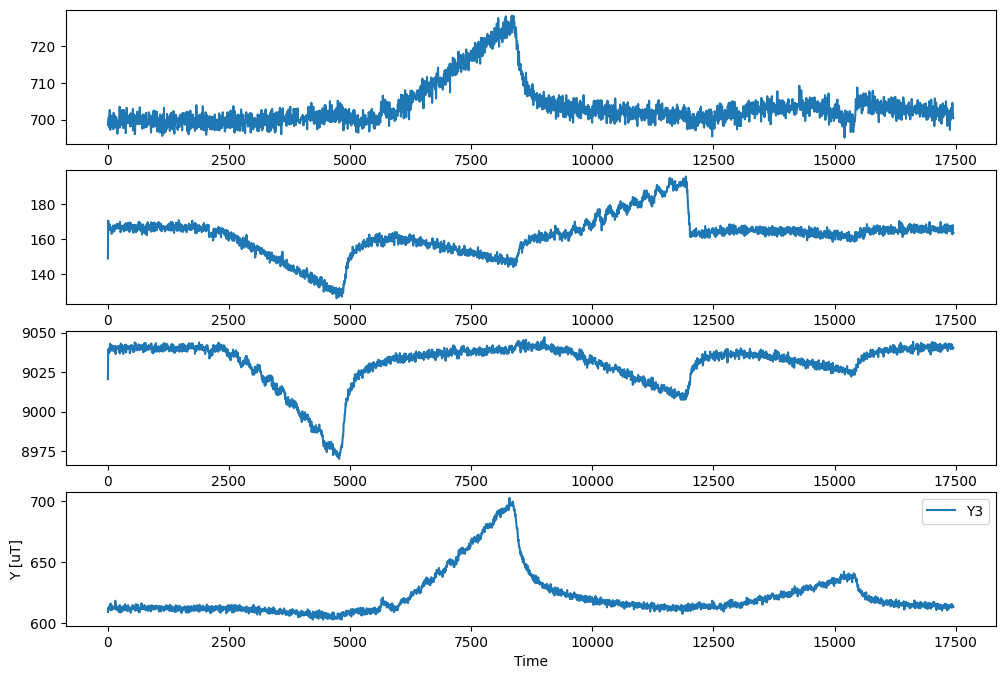

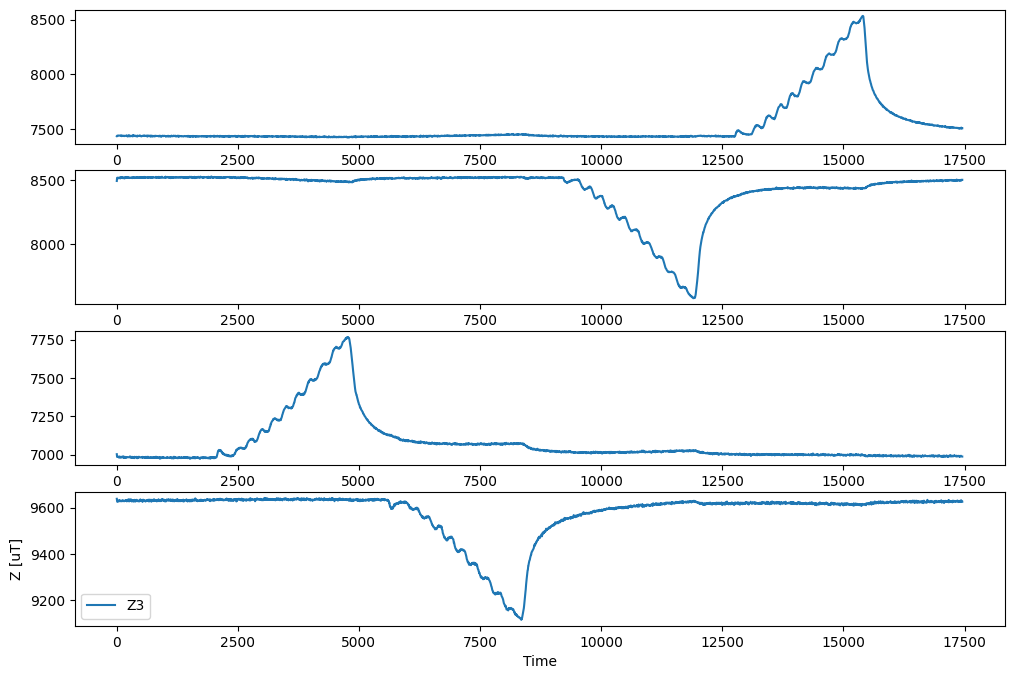

In [14]:
pf.plot_meas_axis(normal_force_df, 'X', ARRAY_SIZE)
pf.plot_meas_axis(normal_force_df, 'Y', ARRAY_SIZE)
pf.plot_meas_axis(normal_force_df, 'Z', ARRAY_SIZE)

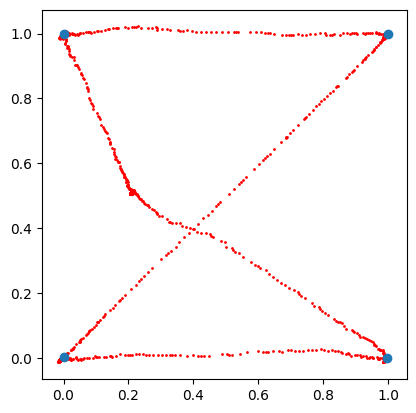

In [15]:
# Extract boundary points
center_points, normal_force_normalized_df = cf.extract_center_points_from_data(normal_force_df, ARRAY_SIZE_SUB, normalize=True) 

plt.scatter(normal_force_normalized_df['X'], normal_force_normalized_df['Y'],s=1, c='r')
plt.scatter(center_points[:,0], center_points[:,1])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

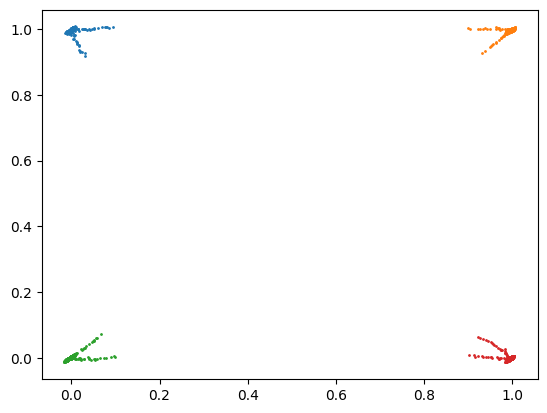

In [16]:
# Now split into the regions used for fitting
regions_data = cf.split_data_into_regions(normal_force_normalized_df, center_points, min_distance=0.1)

for data in regions_data:
  plt.scatter(data['X'], data['Y'],s=1)
plt.show()

In [17]:
normal_force_models_taxels = []

for region in regions_data:
  
  # Find largest activation 
  Z_measurements = region[[f'Z{i}' for i in range(ARRAY_SIZE)]]
  largest_activation_in_region_index = np.argmax(np.max(Z_measurements) - np.min(Z_measurements))
  
  print("Taxel {} has largest activation".format(largest_activation_in_region_index))
  
  X = Z_measurements[f'Z{largest_activation_in_region_index}'].to_numpy().reshape(-1, 1)
  y = region[['F_z']]
  
  # Fit
  model = reg.create_regression_pipeline_and_fit(X, y)
  model.activation_index = largest_activation_in_region_index
  
  normal_force_models_taxels.append(model)
  

Taxel 2 has largest activation
Score:  0.7599189462186822
MSE:  2.684884182128356
Taxel 3 has largest activation
Score:  0.7735373442230244
MSE:  2.4798193163688187
Taxel 1 has largest activation
Score:  0.8283983429905749
MSE:  1.9851085183674417
Taxel 0 has largest activation
Score:  0.8065261517688753
MSE:  2.1692744227169065


/home/lowiek/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/lowiek/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.5076e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/lowiek/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: In a future version, DataFrame.m

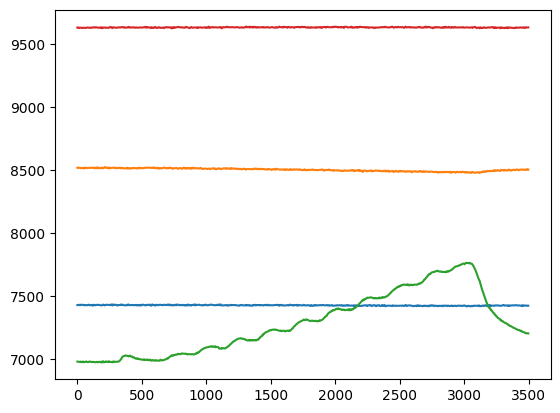

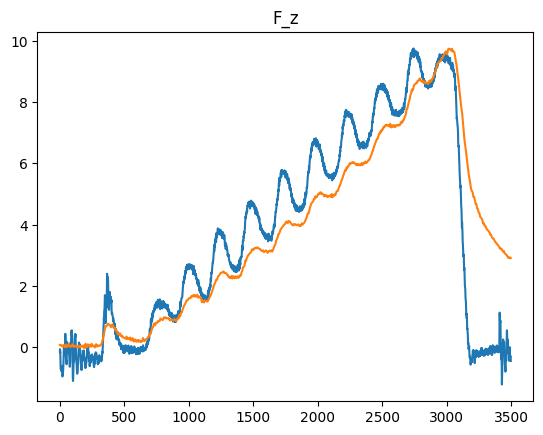

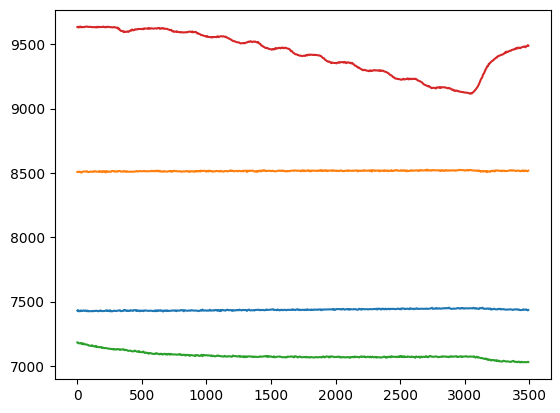

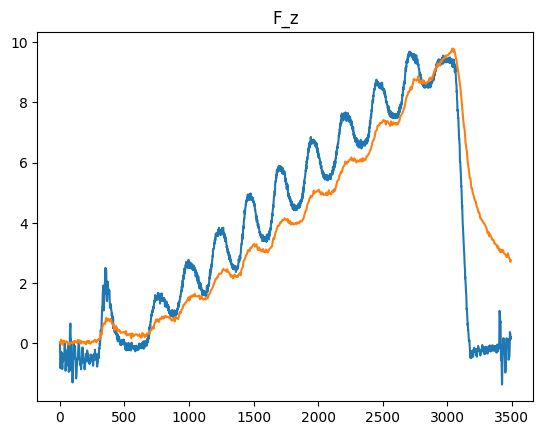

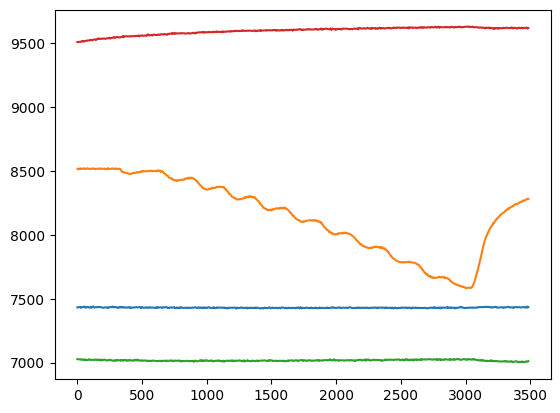

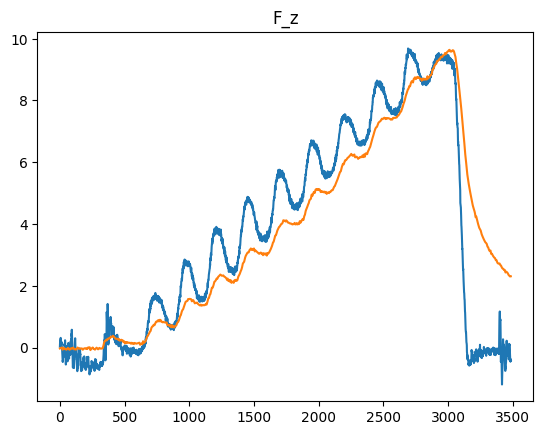

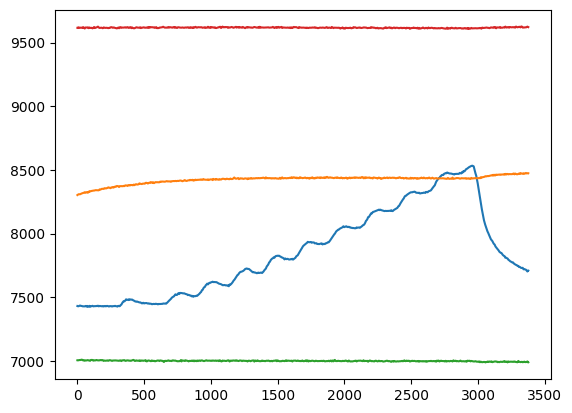

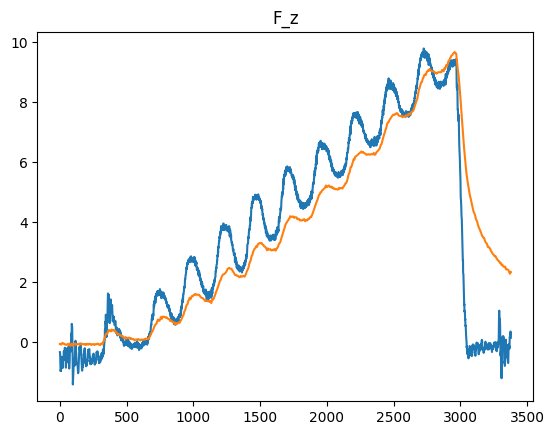

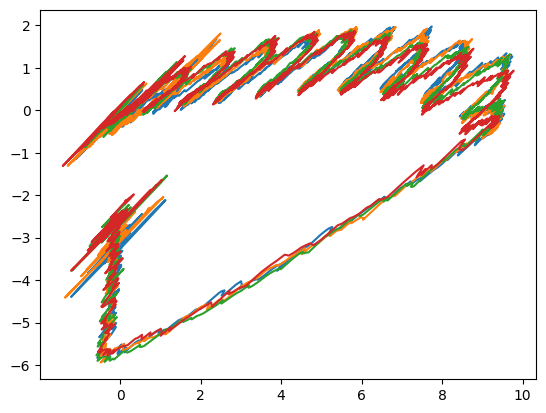

In [18]:
errors = []
indices = []

for model, region in zip(normal_force_models_taxels, regions_data):
  
  indices.append(model.activation_index)
  
  # Predict
  Z_measurements = region[[f'Z{i}' for i in range(ARRAY_SIZE)]]
  X = Z_measurements[f'Z{model.activation_index}'].to_numpy().reshape(-1, 1)
  Y_pred = model.predict(X)
  
  # Plot inputs
  plt.plot(Z_measurements)
  plt.show()
  
  # Plot against actual
  for i, name in enumerate(['F_z']):
    plt.figure()
    plt.title(name)
    plt.plot(region[name])
    plt.plot(Y_pred)
    plt.show()
    
  # Calculate error
  errors.append(region[name].to_numpy() - Y_pred[:, 0])

  plt.show()
  
i = 0
for index, err in zip(indices, errors):
  
  plt.plot(regions_data[i][f'F_z'], err)
  i += 1

/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


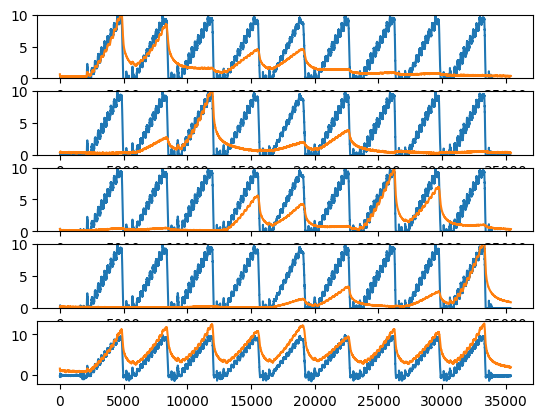

In [19]:
# Apply models on new data (with subsampling)
normal_force_df_val = cf.prepare_data_for_fitting(f"table_calibration/2x2_grid_subsampling_x2_08032024_schroef2_designremko", ARRAY_SIZE, SENSOR_LAG)

normal_force_models_taxels_fixed = [normal_force_models_taxels[i] for i in [3, 2, 0, 1]]

F_zi = [model.predict(normal_force_df_val[[f'Z{model.activation_index}']]) for model in normal_force_models_taxels]

fig, axs = plt.subplots(ARRAY_SIZE + 1, 1)
for i in range(ARRAY_SIZE):
  axs[i].plot(normal_force_df_val[f'F_z'])
  axs[i].plot(F_zi[i])
  
  axs[i].set_ylim((0, 10))

axs[-1].plot(normal_force_df_val['F_z'])
axs[-1].plot(np.sum(F_zi, axis=0))

plt.show()


# Option 1.1:
1 groot model

In [27]:
ARRAY_SUB_SIZE = 16
normal_force_df = cf.prepare_data_for_fitting("table_calibration/2x2_grid_subsampling_x3_08032024_schroef2", ARRAY_SIZE, SENSOR_LAG)
center_points, normal_force_normalized_df = cf.extract_center_points_from_data(normal_force_df, ARRAY_SUB_SIZE, normalize=True) 

(59476, 23)
(59476, 23)


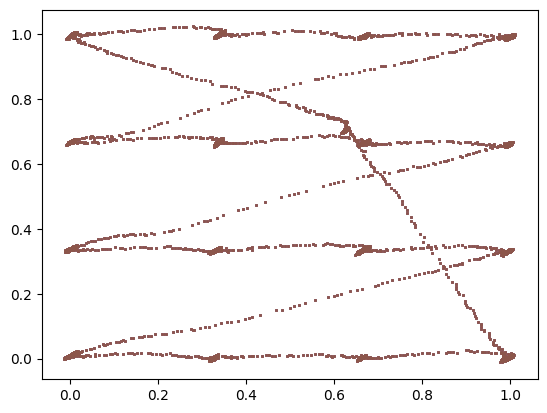

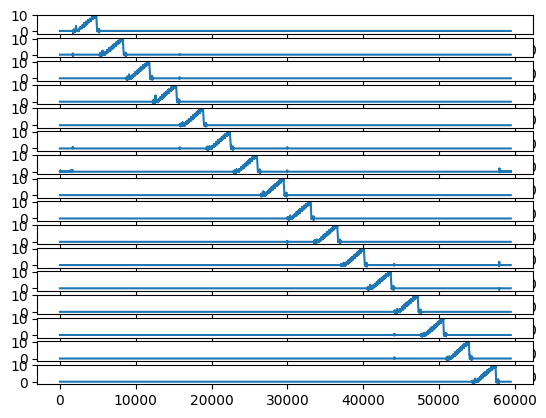

In [28]:
full_regions = cf.split_data_into_regions_full(normal_force_normalized_df, center_points, data_columns + ['F_z'], min_distance=9999)

for data in full_regions:
  plt.scatter(data['X'], data['Y'],s=1)
plt.show()

fig, axs = plt.subplots(ARRAY_SUB_SIZE, 1)
for i in range(ARRAY_SUB_SIZE):
  axs[i].plot(full_regions[i][f'F_z'])
  # axs[i].set_ylim((0, 10))

In [29]:
#Create a big model
X = normal_force_normalized_df[[f'Z{i}' for i in range(ARRAY_SIZE)]]
y = [region['F_z'] for region in full_regions]
y = np.array(y).T

print(X.shape)
print(y.shape)

big_model = reg.create_regression_pipeline_and_fit(X, y)

(59476, 4)
(59476, 16)
Score:  0.7837988301067377
MSE:  0.30848265346326664


/home/lowiek/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.66998e-28): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


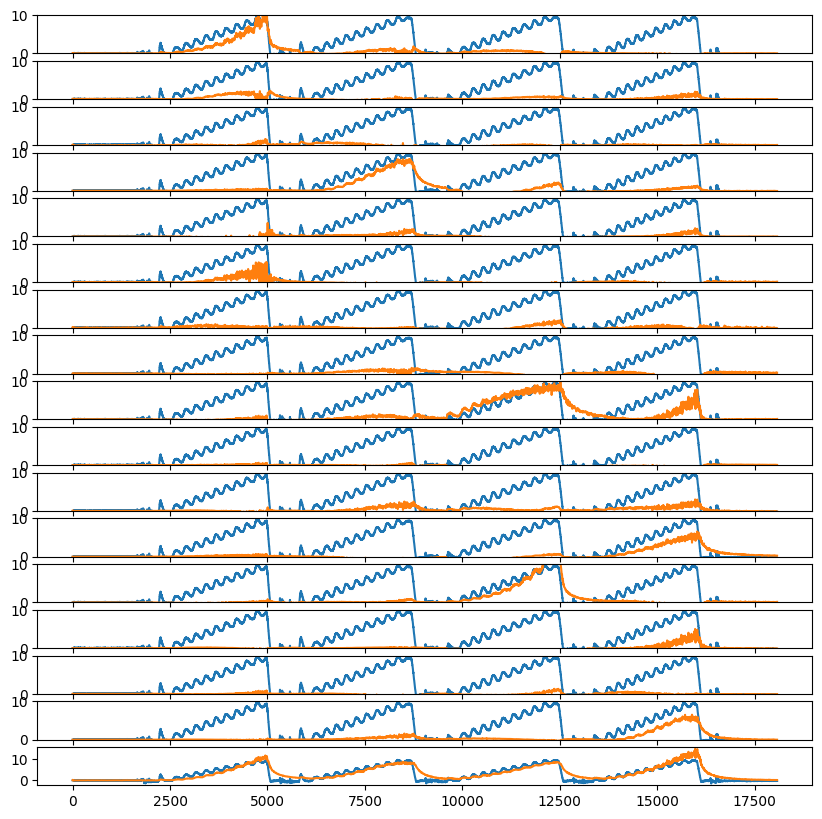

In [30]:
# Apply models on new data (with subsampling)
normal_force_df_val = cf.prepare_data_for_fitting(f"table_calibration/2x2_grid_subsampling_x1_08032024_schroef2", ARRAY_SIZE, SENSOR_LAG)

normal_force_models_taxels_fixed = [normal_force_models_taxels[i] for i in [3, 2, 0, 1]]

X = normal_force_df_val[[f'Z{i}' for i in range(ARRAY_SIZE)]]
F_zi = big_model.predict(X)
F_zi = [F_zi[:, i] for i in range(ARRAY_SUB_SIZE)]

fig, axs = plt.subplots(ARRAY_SUB_SIZE + 1, 1, figsize=(10, 10))
for i in range(ARRAY_SUB_SIZE):
  axs[i].plot(normal_force_df_val[f'F_z'])
  axs[i].plot(F_zi[i])
  
  axs[i].set_ylim((0, 10))

axs[-1].plot(normal_force_df_val['F_z'])
axs[-1].plot(np.sum(F_zi, axis=0))

plt.show()


# Option 2
All Z-components -> F_z, X, Y

In [39]:
X = normal_force_df[[f'Z{i}' for i in range(ARRAY_SIZE)]]
y = normal_force_df[['F_z', 'X', 'Y']]

model_option_2 = reg.create_regression_pipeline_and_fit(X, y)

Score:  0.8853545949787504
MSE:  0.31825600088448663


/home/lowiek/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.04606e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


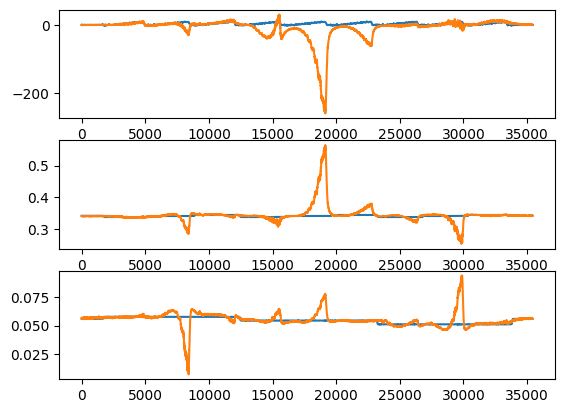

In [44]:
normal_force_df_val = cf.prepare_data_for_fitting(f"table_calibration/2x2_grid_subsampling_x2_08032024_schroef2", ARRAY_SIZE, SENSOR_LAG)
y = cf.validate_data(normal_force_df_val, model_option_2, ARRAY_SIZE)

fig, axs = plt.subplots(3, 1)

axs[0].plot(normal_force_df_val[f'F_z'])
axs[0].plot(y[:, 0])

axs[1].plot(normal_force_df_val[f'X'])
axs[1].plot(y[:, 1])

axs[2].plot(normal_force_df_val[f'Y'])
axs[2].plot(y[:, 2])

plt.show()


# Option 3: taxel model interpolation
So predict superresolution based on taxel models (from option 1)

In [144]:
def interpolate_normalized(F_zi, x, y):
  """
  Interpolate the force at a given point.
  F_zi should be (x1, y1), (x1, y2), (x2, y1), (x2, y2)
  """
  
  x1, y1 = 0, 0
  x2, y2 = 1, 1
  
  F_matrix = np.array([[F_zi[0], F_zi[1]], [F_zi[2], F_zi[3]]])
  
  tmp = np.zeros((2, F_matrix.shape[-1]))
  for i in range(F_matrix.shape[-1]):
    tmp[:, i] = F_matrix[:, :, i] @ np.array([y2 - y, y - y1]).T
  
  tmp2 = np.zeros((F_matrix.shape[-1]))
  for i in range(F_matrix.shape[-1]):
    tmp2[i] = np.array([x2 - x, x - x1]).T @ tmp[:, i]
  
  return 1 / ((x2 - x1) * (y2 - y1)) * tmp2
  

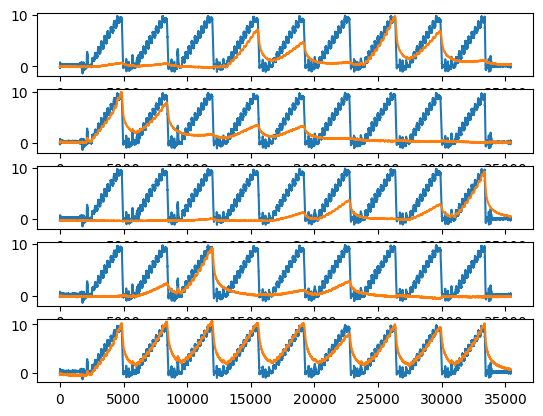

In [154]:
# We have a combined_model that returns the F_z components from every taxel based on the Z measurements
# Now we use this model to fit a model that predicts the F_z component, given Z measurements and the X and Y position of the wanted location
# OR we give it Z measurements, and it returns the F_z component at all virtual locations at once

# First we make the predictions from the option 1 models
subsampled_force_df = cf.prepare_data_for_fitting(f"table_calibration/2x2_grid_subsampling_x2_08032024_schroef2", ARRAY_SIZE, SENSOR_LAG)
F_zi = combined_model.predict(subsampled_force_df[[f'Z{i}' for i in range(ARRAY_SIZE)]].to_numpy())
F_zi_fixed = [F_zi[:, 1], F_zi[:, 2], F_zi[:, 0], F_zi[:, 3]]

fig, axs = plt.subplots(ARRAY_SIZE + 1, 1)
for i in range(ARRAY_SIZE):
  axs[i].plot(subsampled_force_df[f'F_z'])
  axs[i].plot(F_zi_fixed[i])

axs[-1].plot(subsampled_force_df['F_z'])
axs[-1].plot(np.sum(F_zi_fixed, axis=0))

plt.show()

(9, 35428)


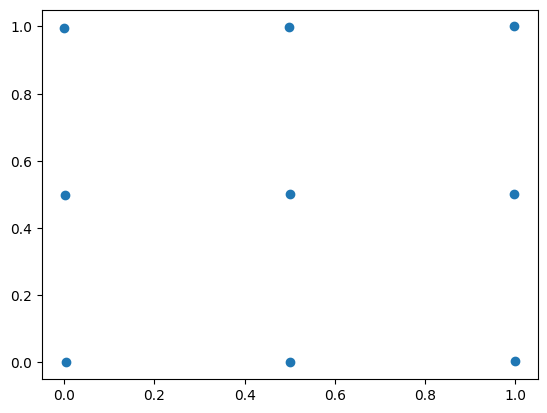

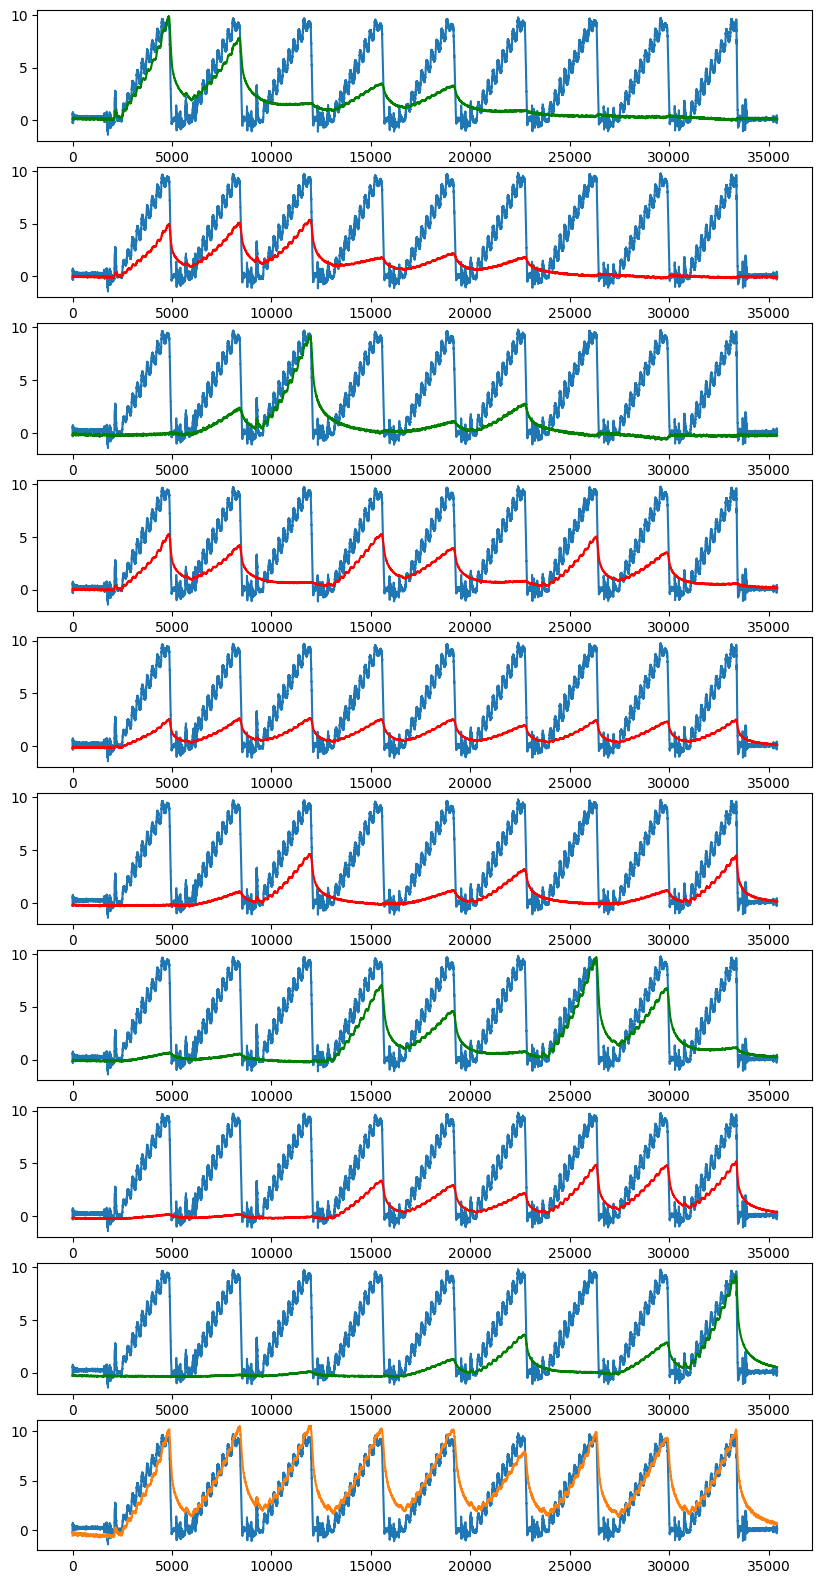

In [158]:
# Test the interpolation model on the different points
array_size = 9
center_points_val, _ = cf.extract_center_points_from_data(subsampled_force_df, array_size, normalize=True)
plt.scatter(center_points_val[:,0], center_points_val[:,1])

F_zi_int = []

for point in center_points_val:
  F_zi_int.append(interpolate_normalized([F_zi[:, 1], F_zi[:, 2], F_zi[:, 0], F_zi[:, 3]], point[0], point[1]))
  
fig, axs = plt.subplots(array_size + 1, 1, figsize=(10, 20))
for i in range(array_size):
  c = 'r'
  if i == 0 or i == 2 or i == 6 or i == 8:
    c = 'g'
    
  axs[i].plot(subsampled_force_df[f'F_z'])
  axs[i].plot(F_zi_int[i], c=c)

axs[-1].plot(subsampled_force_df['F_z'])
axs[-1].plot(np.sum(F_zi_int, axis=0) / array_size * 4)

# Option 4: superresolution based on previous model
So we take the Z measurements of a 4x4 model, we put it in to the big model (option 1 or something like that), we get the F_z components out. Then we put those components into a new model, together with XY and predict F_z

(59476, 23)
(59476, 23)


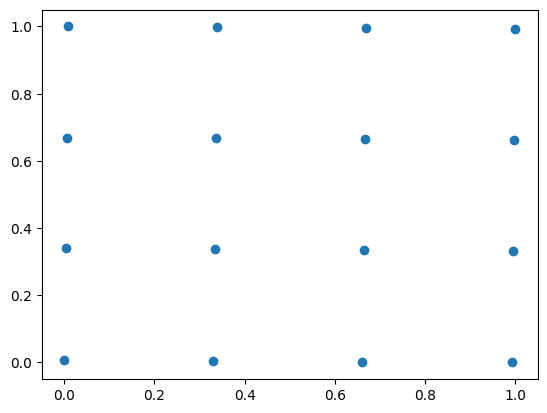

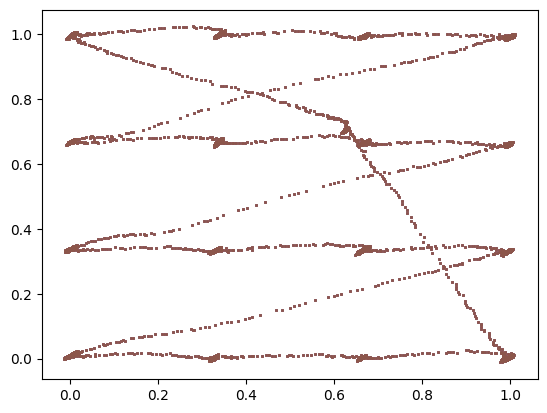

In [124]:
# First load in superresolution data
# Step 0
array_size = 4
array_sub_size = 16
super_res_df = cf.prepare_data_for_fitting(f"table_calibration/2x2_grid_subsampling_x3_08032024_schroef2", array_size, SENSOR_LAG)
center_points_sr, super_res_normalized_df = cf.extract_center_points_from_data(super_res_df, array_sub_size, normalize=True)

# Split into regions
full_regions_sr = cf.split_data_into_regions_full(super_res_normalized_df, center_points_sr, data_columns + ['F_z'], min_distance=0.1)

plt.scatter(center_points_sr[:,0], center_points_sr[:,1])
plt.show()

for data in full_regions_sr:
  plt.scatter(data['X'], data['Y'],s=1)

Score:  0.8114805049672812
MSE:  0.26450324511422396


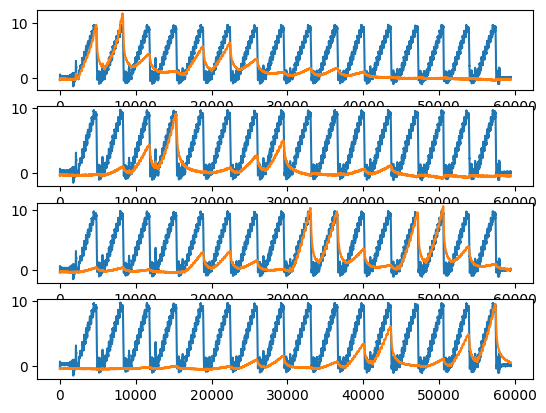

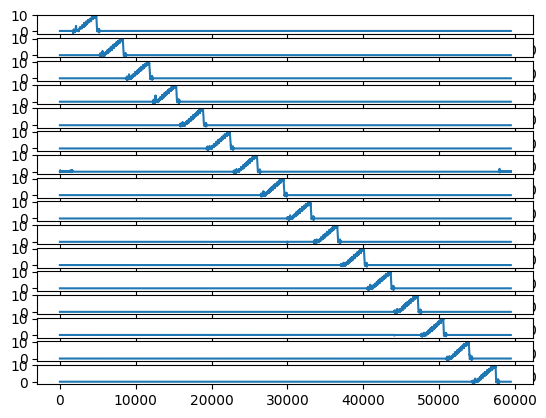

In [125]:
#
# AGGREGATED MODEL PER VIRTUAL TAXEL (UNCOUPLED)
#
# # Now make an aggregated model per virtual taxel. Taking in the forces on the actual taxels
# aggregate_models = []

# F_zis = []

# for region in full_regions_sr:

#     # Predict forces on the actual taxels (big model)
#     X = region[[f'Z{i}' for i in range(array_size)]]
#     F_zi = []
#     for model in normal_force_models_taxels:
#         F_zi.append(model.predict(X[f'Z{model.activation_index}'].to_numpy().reshape(-1, 1))[:, 0])
    
#     F_zi = np.array(F_zi).T
#     F_zis.append(F_zi)

#     # Now give this as input, together with the F_z of the region
#     y = region['F_z']
#     model = reg.create_regression_pipeline_and_fit(F_zi, y)
#     aggregate_models.append(model)

#
# ONE BIG AGGREGATED MODEL
#
# Now make one big aggregated model, taking in the forces on the actual taxels
F_zi = []
F_zi = []
X = super_res_normalized_df[[f'Z{i}' for i in range(array_size)]]
for model in normal_force_models_taxels:
    F_zi.append(model.predict(X[f'Z{model.activation_index}'].to_numpy().reshape(-1, 1))[:, 0])
    
# Plot
fig, axs = plt.subplots(array_size, 1)
for i in range(array_size):
  axs[i].plot(super_res_normalized_df[f'F_z'])
  axs[i].plot(F_zi[i])
  
# Also plot y labels
y = [region['F_z'] for region in full_regions_sr]
y = np.array(y).T

fig, axs = plt.subplots(array_sub_size, 1)
for i in range(array_sub_size):
  axs[i].plot(y[:, i])
  
# Now make the model
big_aggregated_model = reg.create_regression_pipeline_and_fit(np.array(F_zi).T, y)

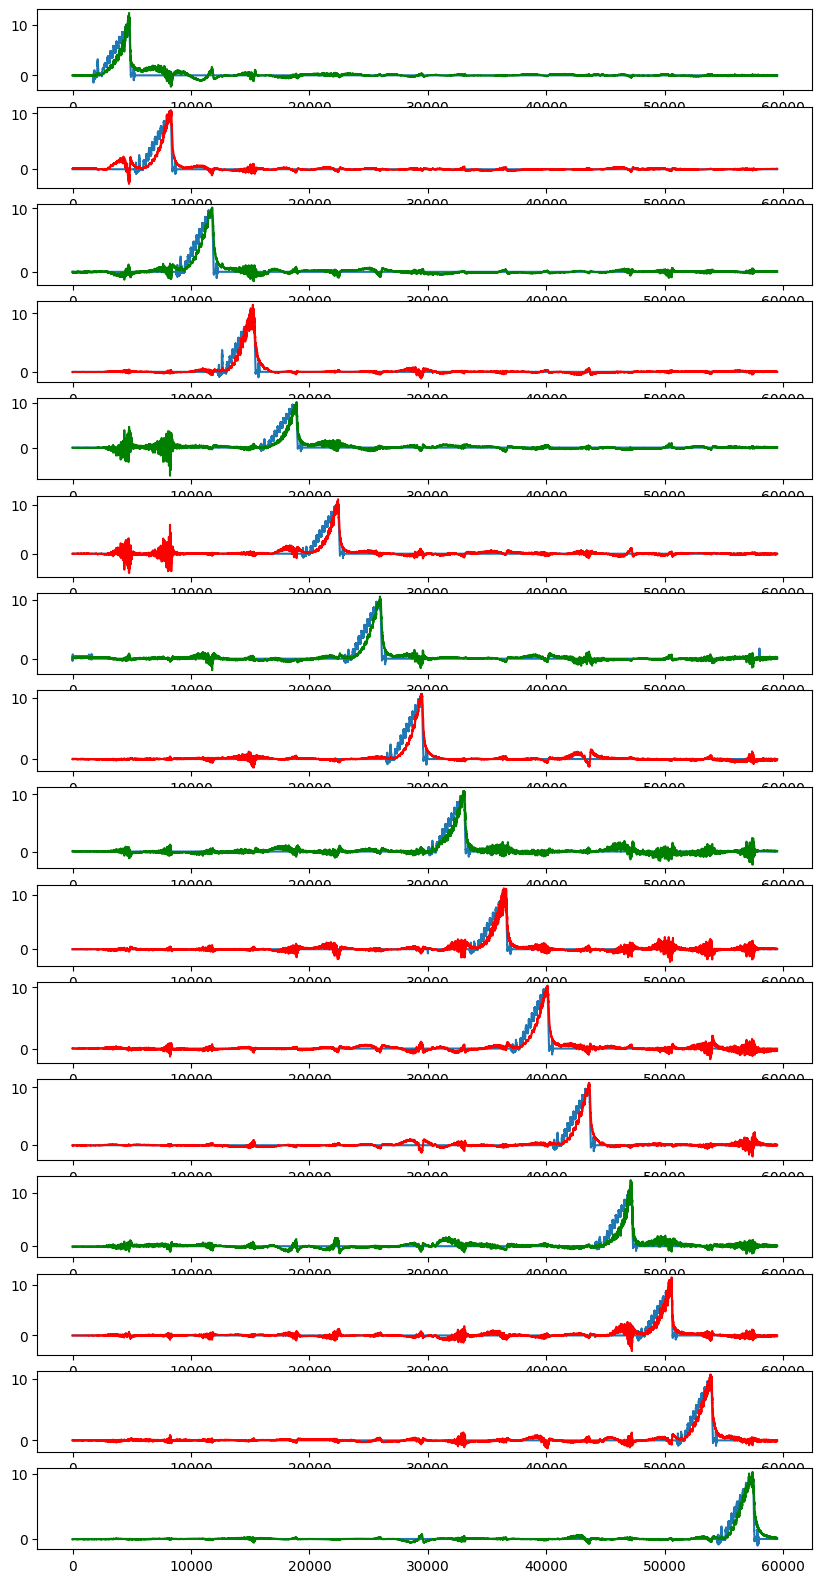

In [127]:
#
# AGGREGATED MODEL PER VIRTUAL TAXEL (UNCOUPLED)
#
# # 
# # 
# # "Training check": just to see if the models are fitted OK
# int_F_z = []
# for F_zi, model in zip(F_zis, aggregate_models):
    
#     X = F_zi
#     int_F_z.append(model.predict(X))
    
# fig, axs = plt.subplots(array_sub_size, 1, figsize=(10, 20))
# for i in range(array_sub_size):
#   c = 'r'
#   if i == 0 or i == 2 or i == 6 or i == 8:
#     c = 'g'
    
#   axs[i].plot(full_regions_sr[i][f'F_z'])
#   axs[i].plot(int_F_z[i], c=c)

#
# ONE BIG AGGREGATED MODEL
#
# "Training check": just to see if the models are fitted OK
y_pred = big_aggregated_model.predict(np.array(F_zi).T) 

# Plot
fig, axs = plt.subplots(array_sub_size, 1, figsize=(10, 20))
for i in range(array_sub_size):
  c = 'r'
  if array_sub_size == 9 and i == 0 or i == 2 or i == 6 or i == 8:
    c = 'g'
  
  if array_sub_size == 16 and i == 0 or i == 4 or i == 12 or i == 15:
    c = 'g'
    
  axs[i].plot(full_regions_sr[i][f'F_z'])
  axs[i].plot(y_pred[:, i], c=c)

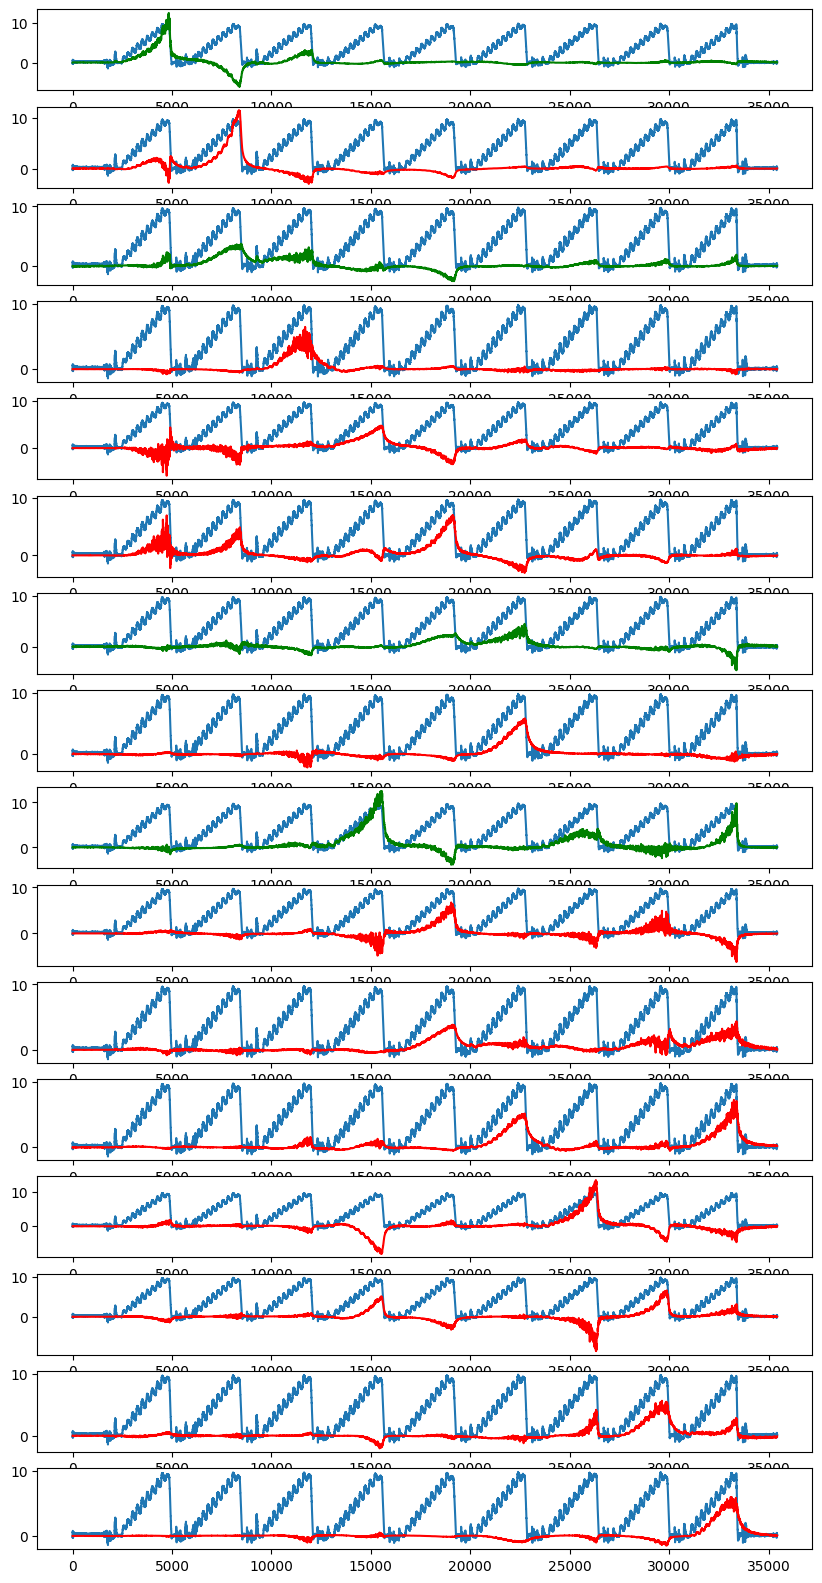

In [129]:
#
# AGGREGATED MODEL PER VIRTUAL TAXEL (UNCOUPLED)
#
# # Validation test. Now do the same, but on a complete dataset
# super_res_df_val = cf.prepare_data_for_fitting(f"table_calibration/2x2_grid_subsampling_x2_08032024_schroef2", array_size, SENSOR_LAG)

# # First convert measurements to F_zi
# X = super_res_df_val[[f'Z{i}' for i in range(array_size)]]
# F_zi = []
# for model in normal_force_models_taxels:
#     F_zi.append(model.predict(X[f'Z{model.activation_index}'].to_numpy().reshape(-1, 1))[:, 0])
# F_zi = np.array(F_zi).T
# print(F_zi.shape)

# # Plot F_zi
# fig, axs = plt.subplots(array_size, 1)
# for i in range(array_size):
#   axs[i].plot(super_res_df_val[f'F_z'])
#   axs[i].plot(F_zi[:, i])

# # Then use the aggregate model to predict the F_z in the virtual taxels
# int_F_z = []
# for model in aggregate_models:
#     X = F_zi
#     int_F_z.append(model.predict(X))
    
# # Plot!
# fig, axs = plt.subplots(array_sub_size, 1, figsize=(10, 20))
# for i in range(array_sub_size):
#   c = 'r'
#   if i == 0 or i == 2 or i == 6 or i == 8:
#     c = 'g'
    
#   axs[i].plot(super_res_df_val[f'F_z'])
#   axs[i].plot(int_F_z[i], c=c)
#   axs[i].set_ylim((0, 10))

#
# ONE BIG AGGREGATED MODEL
#
# "Training check": just to see if the models are fitted OK
super_res_df_val = cf.prepare_data_for_fitting(f"table_calibration/2x2_grid_subsampling_x2_08032024_schroef2", array_size, SENSOR_LAG)

# First convert measurements to F_zi
X = super_res_df_val[[f'Z{i}' for i in range(array_size)]]
F_zi = []
for model in normal_force_models_taxels:
    F_zi.append(model.predict(X[f'Z{model.activation_index}'].to_numpy().reshape(-1, 1))[:, 0])
F_zi = np.array(F_zi).T
    
# Convert to virtual taxels F_z
y_pred = big_aggregated_model.predict(F_zi) 

# Plot
fig, axs = plt.subplots(array_sub_size, 1, figsize=(10, 20))
for i in range(array_sub_size):
  c = 'r'
  if i == 0 or i == 2 or i == 6 or i == 8:
    c = 'g'
    
  axs[i].plot(super_res_df_val[f'F_z'])
  axs[i].plot(y_pred[:, i], c=c)